<h1> Optimierung der Einsatzplanung im Rettungsdienst durch die Anwendung von Deep Learning-Modellen zur Zeitreihenprognose </h1>
<p>Bachelorarbeit zur Erlangung des Bachelor-Grades<br>
Bachelor of Science im Studiengang Data and Information Science<br>
an der Fakultät für Informations- und Kommunikationswissenschaften<br>
der Technischen Hochschule Köln</p>

<p>
    <b>vorgelegt von:</b> Annemarie Szyprons<br>
    <b>Matrikel-Nr.:</b> 11141379<br>
    <b>eingereicht bei:</b> Prof. Dr. Gernot Heisenberg und Dr. Frederik Schütte
</p>

Köln, 14.03.2024

<h2>Aufbau der Test- und Trainingsumgebung</h2>
<p>Im Folgenden wird die Test- und Trainingsumgebung aufgebaut. Zunächst werden die Daten eingelesen und aufbereitet. Sie werden normalisiert und in eine dreidimensionale Form umcodiert, sodass sie als überwachtes Lernproblem für das LSTM-Modell genutzt werden können.</p>

In [1]:
# load dependencies
import numpy as np
from numpy import concatenate

import tensorflow as tf
from tensorflow import keras

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.layers import LSTM
from keras.optimizers import Adam

from math import sqrt

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

<h2>Vorbereitung der Daten</h2>

In [2]:
dataset = pd.read_csv('Einsatzzeitreihe_Notfallrettung_LSTM.csv', decimal=',', sep=';') # load dataset
dataset.tail()

,ZEIT,Anzahl,MONAT,STUNDE,WOCHENTAG,b_Feiertag
46700,2023-04-30 20:00:00,2,4,20,7,0
46701,2023-04-30 21:00:00,0,4,21,7,0
46702,2023-04-30 22:00:00,1,4,22,7,0
46703,2023-04-30 23:00:00,3,4,23,7,0
46704,2023-05-01 00:00:00,0,5,0,7,1


In [3]:
dataset['ZEIT'] = pd.to_datetime(dataset['ZEIT']) 
dataset = dataset.loc[(dataset['ZEIT'] < '2023-05-01 00:00:00')] # remove 01.05.2023 from data

test_size = dataset.loc[(dataset['ZEIT'] >= '2022-01-01 00:00:00')] # filter test data from 2022-01-01
test_size = len(test_size) # length

dataset = dataset.set_index('ZEIT') # set timestamps as index

In [4]:
dataset = dataset.drop(columns=['b_Feiertag']) # columns will not be used in model
dataset = dataset.reindex(columns=['Anzahl', 'STUNDE', 'WOCHENTAG', 'MONAT'])

# univariate timeseries
#dataset = dataset.drop(columns=['b_Feiertag', 'STUNDE', 'WOCHENTAG', 'MONAT']) # drop columns for univariate timeseries
#dataset = dataset.reindex(columns=['Anzahl'])

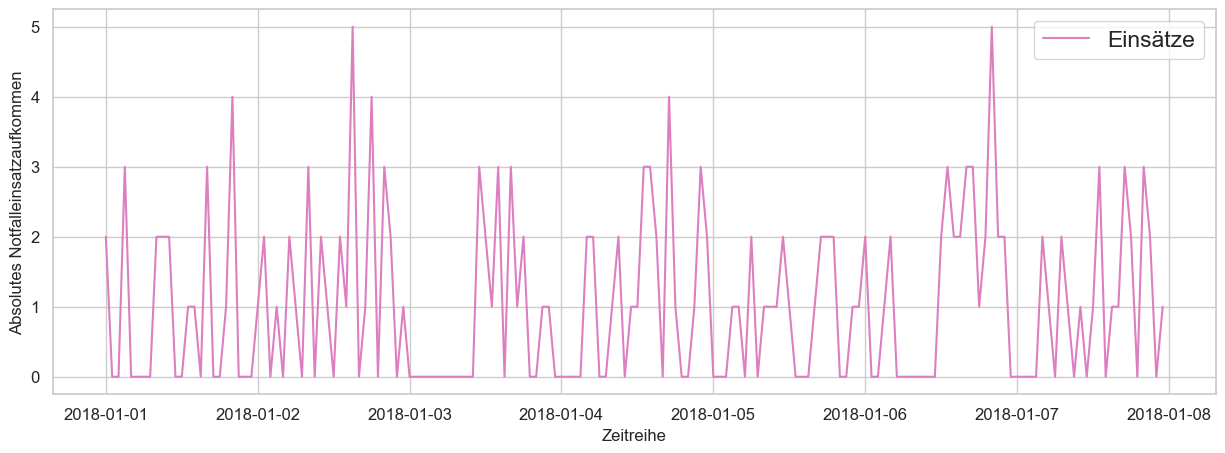

In [5]:
# plot emergency demand as time series
days_to_print = 24 * 7

plt.figure(figsize=(15,5))
plt.plot(dataset['Anzahl'][:days_to_print], label='Einsätze', color='C6')
plt.xlabel("Zeitreihe", fontname="Arial", fontsize=12)
plt.ylabel("Absolutes Notfalleinsatzaufkommen", fontname="Arial", fontsize=12)
plt.yticks(fontname = "Arial", fontsize=12)
plt.xticks(fontname = "Arial", fontsize=12)
plt.grid(axis='both', which='major', linestyle='-')
plt.legend();

In [6]:
train_size = len(dataset) - test_size
train, test = dataset.iloc[0:train_size], dataset.iloc[train_size:len(dataset)] # split test and train data
print(train.shape, test.shape)

(35064, 4) (11640, 4)


<p>Normalisieren der Daten mittels MinMaxScaler, um die Daten in einen gemeinsamen Wertebereich im Intervall [0, 1] zu transformieren.</p>

In [7]:
# normalize data
scaler = MinMaxScaler()
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

<p>Umwandlung in ein überwachtes Lernproblem zu einer Zeitreihe t-1, t-2, ..., t-n als Eingabevektor. </p>

In [8]:
# convert series to supervised learning (sliding window)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	
    # input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	
    # forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
    # put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	
    # drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [9]:
# frame as supervised learning
n_hours = 12 # hours to look back to convert series to supervised learning (sliding window)
n_features = 4

train_reframed = series_to_supervised(data=train_scaled, n_in=n_hours, n_out=1) 
test_reframed = series_to_supervised(data=test_scaled, n_in=n_hours, n_out=1) 

In [10]:
# split into train and test sets
train_reframed = train_reframed.values
test_reframed = test_reframed.values

# split into input and outputs
n_obs = n_hours * n_features
X_train, y_train = train_reframed[:, :n_obs], train_reframed[:, -n_features]
X_test, y_test = test_reframed[:, :n_obs], test_reframed[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_hours, n_features))
X_test = X_test.reshape((X_test.shape[0], n_hours, n_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(35052, 12, 4) (35052,) (11628, 12, 4) (11628,)


<h3>Modell-Definition</h3>

In [11]:
# define network
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1))

In [12]:
# compile network
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

<h3>Modell Training</h3>

In [ ]:
# fit network
model_fit = model.fit(X_train, y_train, epochs=15, batch_size=48, validation_data=(X_test, y_test)) 

Epoch 1/15
731/731 [==============================] - 91s 116ms/step - loss: 0.0165 - mean_absolute_error: 0.1017 - val_loss: 0.0168 - val_mean_absolute_error: 0.1056
Epoch 2/15
731/731 [==============================] - 29s 40ms/step - loss: 0.0159 - mean_absolute_error: 0.0997 - val_loss: 0.0171 - val_mean_absolute_error: 0.1024
Epoch 3/15
731/731 [==============================] - 28s 39ms/step - loss: 0.0158 - mean_absolute_error: 0.0993 - val_loss: 0.0168 - val_mean_absolute_error: 0.1020
Epoch 4/15
731/731 [==============================] - 25s 35ms/step - loss: 0.0158 - mean_absolute_error: 0.0992 - val_loss: 0.0169 - val_mean_absolute_error: 0.1027
Epoch 5/15
731/731 [==============================] - 51s 70ms/step - loss: 0.0157 - mean_absolute_error: 0.0993 - val_loss: 0.0168 - val_mean_absolute_error: 0.1018
Epoch 6/15
731/731 [==============================] - 14s 20ms/step - loss: 0.0157 - mean_absolute_error: 0.0993 - val_loss: 0.0169 - val_mean_absolute_error: 0.1021
Epo

In [ ]:
model.save('lstm_model_final_20230314.keras', overwrite=False, save_format='keras') # save model 

<h2>Test und Analyse</h2>
<p>Im Rahmen der Forschungsfrage 1 werden die Parameter für das Modell optimiert. Folgende Parameter werden im Trainingsprozess experimentell angepasst: Lag-Wert, Anzahl der LSTM-Layer, Neuronen im LSTM-Layer, Lernrate, Anzahl der Epochen, Batch-Größe, Rate des Dropouts. Die Ergebnisse werden in einem Testplan dokumentiert und im Anschluss ausgewertet.</p>

In [ ]:
# evaluate the model
# compare test and trainings loss
plt.figure(figsize=(13,4))
plt.plot(model_fit.history['loss'], label='Train Loss', color='C1')
plt.plot(model_fit.history['val_loss'], label='Val Loss', color='C3')
plt.title('Model loss LSTM', size=11, fontname='Arial')
plt.ylabel('Loss', size=11, fontname='Arial')
plt.xlabel('Anzahl Epochen', size=11, fontname='Arial')
plt.yticks(fontname = 'Arial', fontsize=11)
plt.xticks(fontname = 'Arial', fontsize=11)
plt.legend(loc='upper right')
plt.grid(axis='both', which='major', linestyle='--')
plt.show()

<h3>Evaluation</h3>

In [ ]:
# make a prediction
ypred = model.predict(X_test)

In [ ]:
X_test_m1 = X_test.reshape((X_test.shape[0], n_hours*n_features))

In [ ]:
# invert scaling for forecast
inv_ypred = concatenate((ypred, X_test_m1[:, -3:]), axis=1)
inv_ypred = scaler.inverse_transform(inv_ypred)
inv_ypred = inv_ypred[:,0]

In [ ]:
# invert scaling for actual
y_test_m1 = y_test.reshape((len(y_test), 1))
inv_yact = concatenate((y_test_m1, X_test_m1[:, -3:]), axis=1)
inv_yact = scaler.inverse_transform(inv_yact)
inv_yact = inv_yact[:,0]

In [ ]:
# Graph for prediction vs actual
prediction_range = 24*30

aq=[x for x in range(prediction_range)]
plt.figure(figsize=(15,5))
plt.plot(aq, test[:prediction_range].Anzahl, marker='.', label='Tatsächlich', color='C1')
plt.plot(aq, inv_ypred[:prediction_range], label='Prognose LSTM', color='C3')
plt.ylabel('Absolutes Einsatzfahrtaufkommen', size=11)
plt.xlabel('Zeitpunkte im Verlauf', size=11)
plt.yticks(fontname = 'Arial', fontsize=11)
plt.xticks(fontname = 'Arial', fontsize=11)
plt.legend(fontsize=11)
plt.savefig('Prognosemodell_Vorhersage_final_20230314.png')
plt.show();

In [ ]:
# Predictions vs. Actual
train_results = pd.DataFrame(data={'Actuals':inv_yact, 'Train Predictions':inv_ypred})
train_results

In [ ]:
# evaluate metrics
pd.options.display.float_format = '{:.3f}'.format # suppress scientific notation by setting float_format

# Model Evaluation
rmse_lstm = sqrt(mean_squared_error(inv_yact, inv_ypred))
mse_lstm = mean_squared_error(inv_yact, inv_ypred)
mae_lstm = mean_absolute_error(inv_yact, inv_ypred)

eval_lstm = {'LSTM-Modell' : [rmse_lstm, mse_lstm, mae_lstm]}

eval_lstm_df = pd.DataFrame(eval_lstm, columns = ['LSTM-Modell'], index=['RMSE', 'MSE','MAE'])
eval_lstm_df

<h3>Identifizierung von Einsatzspitzen</h3>

In [ ]:
# predictions on train data
X_train_pred = model.predict(X_train)

In [ ]:
# Reshape X_train to match X_prediction's shape
X_train_reshaped = X_train.reshape((X_train.shape[0], n_hours * n_features))

# Calculate MAE loss for each example
train_mae_loss = np.mean(np.abs(X_train_reshaped - X_train_pred), axis=1)

# Plot a histogram for the MAE loss
plt.figure(figsize=(13,5))
plt.hist(train_mae_loss, bins=50, color='C4', alpha=0.7)
plt.ylabel('Häufigkeit', size=11, fontname = 'Arial')
plt.xlabel('MAE Loss der Trainingsdaten', size=11, fontname = 'Arial')
plt.yticks(fontname = 'Arial', fontsize=11)
plt.xticks(fontname = 'Arial', fontsize=11)
plt.savefig('Häufigkeitsverteilung_Trainingsloss_MAE.png')
plt.show()

<h3>Testdaten einfügen</h3>

In [ ]:
td = pd.read_csv('Testdatensatz_Anomalien.csv', decimal=',', sep=';') # load dataset with manually set outliers
td.head()

In [ ]:
td['ZEIT'] = pd.to_datetime(td['ZEIT']) 
td = td.loc[(td['ZEIT'] < '2023-05-04 00:00:00')] 
td = td.set_index('ZEIT') # set timestamps as index

In [ ]:
td.describe()

In [ ]:
# Transform data 
td = td.drop(columns=['b_Feiertag']) # columns will not be used in model
td = td.reindex(columns=['Anzahl', 'STUNDE', 'WOCHENTAG', 'MONAT'])

# normalize data
scaler = MinMaxScaler()
scaler = scaler.fit(td)

td_scaled = scaler.transform(td)

# frame as supervised learning
n_hours = 12 # hours to look back to convert series to supervised learning (sliding window)
n_features = 4

td_reframed = series_to_supervised(data=td_scaled, n_in=n_hours, n_out=1) 

# split dataframe
td_reframed_v = td_reframed.values

# split into input and outputs
n_obs = n_hours * n_features
X_test_td, y_test_td = td_reframed_v[:, :n_obs], td_reframed_v[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
X_test_td = X_test_td.reshape((X_test_td.shape[0], n_hours, n_features))
print(X_test_td.shape, y_test_td.shape)

In [ ]:
# prediction on test data
X_test_pred = model.predict(X_test_td)

In [ ]:
# define function for euclidean distance
def euclidean_distance(x, y):
    return np.linalg.norm(x-y)

In [ ]:
distances = [euclidean_distance(X_test_pred, y_test_td[i]) for i, prediction in enumerate(X_test_pred)] # calculate

In [ ]:
# Plot a histogram for the MAE loss
plt.figure(figsize=(13,4))
plt.hist(distances, bins=50, color='C1', alpha=0.7)
plt.ylabel('Häufigkeit', size=12, fontname = 'Arial')
plt.xlabel('Distanzmetrik', size=12, fontname = 'Arial')
plt.yticks(fontname = 'Arial', fontsize=12)
plt.xticks(fontname = 'Arial', fontsize=12)
plt.show()

In [ ]:
# set threshold for anomaly detection
threshold = 3
print(f'Threshold: {threshold}')

In [ ]:
test_score_df = pd.DataFrame(index=td[n_hours:].index)
test_score_df['euclidean_distance'] = distances
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.euclidean_distance > test_score_df.threshold
test_score_df['Anzahl'] = td[n_hours:].Anzahl

In [ ]:
plt.figure(figsize=(13,5))
plt.plot(test_score_df.index, test_score_df.euclidean_distance, label='Euklidische Distanz', color = 'hotpink')
plt.plot(test_score_df.index, test_score_df.threshold, label='Schwellenwert', color = 'C4')
plt.xticks()
plt.ylabel('Euklidische Distanz', size=11, fontname = 'Arial')
plt.yticks(fontname = 'Arial', fontsize=11)
plt.xticks(fontname = 'Arial', fontsize=11, rotation=25)
plt.legend()
plt.savefig('Euklidische_Distanz_mit_Schwellenwert.png')
plt.show()

In [ ]:
# table of anomalies
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies

In [ ]:
# transform timeseries for plotting
ts = td[n_hours:-1].index
ts = np.asarray(ts).reshape(-1, 1)
ts.shape

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(ts, td[n_hours:-1].Anzahl, label='Fahrten', color='C1')
plt.scatter(x=anomalies.index, y=anomalies.Anzahl, label='Anomalien', color='C3', zorder=5)
plt.ylabel('Einsatzfahrtaufkommen', size=11, fontname='Arial')
plt.xlabel('Zeitreihe', size=11, fontname='Arial')
plt.yticks(fontname = 'Arial', fontsize=11)
plt.xticks(fontname = 'Arial', fontsize=11)
plt.legend(loc='upper right')
plt.grid(axis='both', which='major', linestyle='--')
plt.savefig('Anomalien_Erkennung.png')
plt.show()